# Task 9 – Model-based swing-up planning

This notebook estimates the pendulum parameters $(\alpha_1,\alpha_2)$ from recorded demonstrations and builds a CasADi-based swing-up planner that mirrors Section 6 of Atkeson & Schaal (1997).

In [6]:
import os
import sys
from pathlib import Path

current = Path.cwd()
if (current / 'notebooks').exists():
    PROJECT_ROOT = current
else:
    PROJECT_ROOT = current.parent

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)

Project root: /home/acepeax/Desktop/Studies/MVA/Robotics/Project


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca


from scripts.task_7_env import Task7PendulumEnv, Y_MAX

In [8]:
def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

USE_DOWN_ZERO = False  # shift theta so down=0 (env reports up=0)


In [9]:
from scipy.signal import savgol_filter

def smooth_signal(sig, window=11, poly=3):
    if len(sig) < window:
        return sig.astype(float)
    return savgol_filter(sig, window_length=window, polyorder=poly)


In [10]:
DATA_DIR = Path('data')
MANUAL_DATA_DIR = DATA_DIR / 'task8_manual'
DEFAULT_RECORDING = DATA_DIR / 'swing_up_demo.npz'
SIM_SUBSTEPS = 6  # must match the recording
BASE_DT = 1.0 / 240.0
STEP_DT = BASE_DT * SIM_SUBSTEPS
GRAVITY = 9.81

def _latest_manual_recording():
    recordings = sorted(MANUAL_DATA_DIR.glob('task8_*.npz'))
    return recordings[-1] if recordings else None

print('Using step dt =', STEP_DT)

Using step dt = 0.025


In [11]:
def load_recording(record_file=None):
    if record_file is None:
        if DEFAULT_RECORDING.exists():
            record_file = DEFAULT_RECORDING
        else:
            record_file = _latest_manual_recording()
            if record_file is None:
                raise FileNotFoundError('No recording found in ' + str(MANUAL_DATA_DIR))
    record_file = Path(record_file)
    data = np.load(record_file)
    observations = np.asarray(data['observations'], dtype=np.float64)
    actions = np.asarray(data['actions'], dtype=np.int32)
    rewards = np.asarray(data['rewards'], dtype=np.float64)
    print('Loaded', record_file, 'with', len(actions), 'steps')
    return record_file, observations, actions, rewards

In [12]:
def estimate_pendulum_params(observations_seq, step_dt=STEP_DT, smooth=True):
    """Estimate alpha1, alpha2 from one or multiple observation sequences without crossing boundaries (Y only)."""
    if isinstance(observations_seq, (list, tuple)):
        sequences = [np.asarray(seq, dtype=np.float64) for seq in observations_seq if len(seq) > 1]
    else:
        sequences = [np.asarray(observations_seq, dtype=np.float64)]
    Phi_list, delta_list = [], []
    for obs in sequences:
        if len(obs) < 2:
            continue
        theta = obs[:, 0]
        theta_dot = obs[:, 1]
        ee_vel_y = obs[:, 12]
        if smooth:
            theta = smooth_signal(theta)
            theta_dot = smooth_signal(theta_dot)
            ee_vel_y = smooth_signal(ee_vel_y)
        ay = np.gradient(ee_vel_y, step_dt)
        delta = theta_dot[1:] - theta_dot[:-1]
        phi = np.stack(
            [
                -theta_dot[:-1],
                np.sin(theta[:-1]) + (ay[:-1] / GRAVITY) * np.cos(theta[:-1]),
            ],
            axis=1,
        )
        Phi_list.append(phi)
        delta_list.append(delta)
    if not Phi_list:
        raise ValueError('No valid sequences to fit')
    Phi_all = np.vstack(Phi_list)
    delta_all = np.concatenate(delta_list)
    coeffs, residuals, _, _ = np.linalg.lstsq(Phi_all, delta_all, rcond=None)
    alpha1, alpha2 = coeffs
    alpha1 = max(alpha1, 1e-6)
    alpha2 = max(alpha2, 1e-6)
    residual = residuals[0] if residuals.size else np.sum((Phi_all @ np.array([alpha1, alpha2]) - delta_all) ** 2)
    rmse = np.sqrt(residual / len(delta_all))
    return alpha1, alpha2, rmse


In [13]:
record_file, observations, actions, rewards = load_recording(record_file="data/swing_up_demo.npz")
aug_observations = observations
alpha1, alpha2, rmse = estimate_pendulum_params(observations)
print(f'Estimated alpha1={alpha1:.4f}, alpha2={alpha2:.4f}, velocity RMSE={rmse:.4f}')

Loaded data/swing_up_demo.npz with 86 steps
Estimated alpha1=0.0000, alpha2=0.6740, velocity RMSE=0.2720


In [14]:
def plan_swing_up(
    alpha1,
    alpha2,
    horizon_steps=360,
    step_dt=STEP_DT,
    y_limit=0.6,
    y_vel_limit=6.0,
    start_state=None,
    weights=None,
    initial_guess=None,
):
    if start_state is None:
        start_state = np.array([np.pi - 0.05, 0.0, 0.0, 0.0], dtype=float)
    if weights is None:
        weights = {
            'theta': 3.0,
            'theta_dot': 0.5,
            'y': 1.5,
            'y_dot': 0.2,
            'u': 0.001,
            'terminal_theta': 20.0,
            'terminal_theta_dot': 2.0,
        }
    opti = ca.Opti()
    X = opti.variable(4, horizon_steps + 1)  # theta, theta_dot, y, y_dot
    U = opti.variable(1, horizon_steps)      # commanded acceleration in y
    opti.subject_to(X[:, 0] == start_state.reshape(-1, 1))
    cost = 0
    for k in range(horizon_steps):
        theta = X[0, k]
        theta_dot = X[1, k]
        y = X[2, k]
        y_dot = X[3, k]
        u_y = U[0, k]
        theta_dot_next = (1.0 - alpha1) * theta_dot + alpha2 * (
            ca.sin(theta) + (u_y / GRAVITY) * ca.cos(theta)
        )
        theta_next = theta + step_dt * theta_dot_next
        y_dot_next = y_dot + step_dt * u_y
        y_next = y + step_dt * y_dot_next
        state_next = ca.vertcat(theta_next, theta_dot_next, y_next, y_dot_next)
        opti.subject_to(X[:, k + 1] == state_next)
        opti.subject_to(opti.bounded(-y_limit, y_next, y_limit))
        opti.subject_to(opti.bounded(-y_vel_limit, y_dot_next, y_vel_limit))
        cost += (
            weights['theta'] * theta_next**2
            + weights['theta_dot'] * theta_dot_next**2
            + weights['y'] * y_next**2
            + weights['y_dot'] * y_dot_next**2
            + weights['u'] * (u_y**2)
        )
    theta_T = X[0, -1]
    theta_dot_T = X[1, -1]
    cost += weights['terminal_theta'] * theta_T**2 + weights['terminal_theta_dot'] * theta_dot_T**2
    opti.minimize(cost)
    if initial_guess is not None:
        X_guess, U_guess = initial_guess
        if X_guess.shape == (4, horizon_steps + 1):
            opti.set_initial(X, X_guess)
        if U_guess.shape == (1, horizon_steps):
            opti.set_initial(U, U_guess)
    opti.solver('ipopt', {'ipopt.print_level': 0, 'print_time': False, 'ipopt.max_iter': 4000, 'ipopt.acceptable_tol': 1e-3, 'ipopt.acceptable_obj_change_tol': 1e-4, 'ipopt.mu_strategy': 'adaptive', 'ipopt.hessian_approximation': 'limited-memory', 'ipopt.linear_solver': 'mumps'})
    sol = opti.solve()
    result = {
        'theta': np.array(sol.value(X[0, :])).flatten(),
        'theta_dot': np.array(sol.value(X[1, :])).flatten(),
        'y': np.array(sol.value(X[2, :])).flatten(),
        'y_dot': np.array(sol.value(X[3, :])).flatten(),
        'u': np.array(sol.value(U[0, :])).flatten(),
        'step_dt': step_dt,
    }
    return result


In [15]:
def build_initial_guess_from_demo(observations, horizon_steps, step_dt=STEP_DT):
    def _resample(array, target_len):
        if len(array) == target_len:
            return array.astype(float)
        src = np.linspace(0.0, 1.0, len(array))
        tgt = np.linspace(0.0, 1.0, target_len)
        return np.interp(tgt, src, array)
    theta = smooth_signal(observations[:, 0])
    theta_dot = smooth_signal(observations[:, 1])
    ee_y = smooth_signal(observations[:, 9])
    ee_y_dot = smooth_signal(observations[:, 12])
    ee_y_ddot = np.gradient(ee_y_dot, step_dt)
    theta_samples = _resample(theta, horizon_steps + 1)
    theta_dot_samples = _resample(theta_dot, horizon_steps + 1)
    y_samples = _resample(ee_y, horizon_steps + 1)
    y_dot_samples = _resample(ee_y_dot, horizon_steps + 1)
    X_guess = np.vstack([
        theta_samples,
        theta_dot_samples,
        y_samples,
        y_dot_samples,
    ])
    U_guess = _resample(ee_y_ddot, horizon_steps).reshape(1, -1)
    start_state = X_guess[:, 0]
    return start_state, X_guess, U_guess


In [26]:
horizon = 80
start_state, X_guess, U_guess = build_initial_guess_from_demo(observations, horizon)
start_state = None
plan = plan_swing_up(
    alpha1,
    alpha2,
    horizon_steps=horizon,
    y_limit=0.6,
    y_vel_limit=2.0,
    start_state=start_state,
    weights={
        'theta': 5.0,
        'theta_dot': 0.5,
        'y': 1.5*3,
        'y_dot': 0.9,
        'u': 0.0135,
        'terminal_theta': 30.0,
        'terminal_theta_dot': 4.0,
    },
    initial_guess=(X_guess, U_guess),
)

print('Planned horizon duration:', len(plan['u']) * STEP_DT, 's')

Planned horizon duration: 2.0 s


(<Figure size 1000x900 with 3 Axes>,
 array([<Axes: ylabel='angle [rad]'>, <Axes: ylabel='y [m]'>,
        <Axes: xlabel='time [s]', ylabel='accel'>], dtype=object))

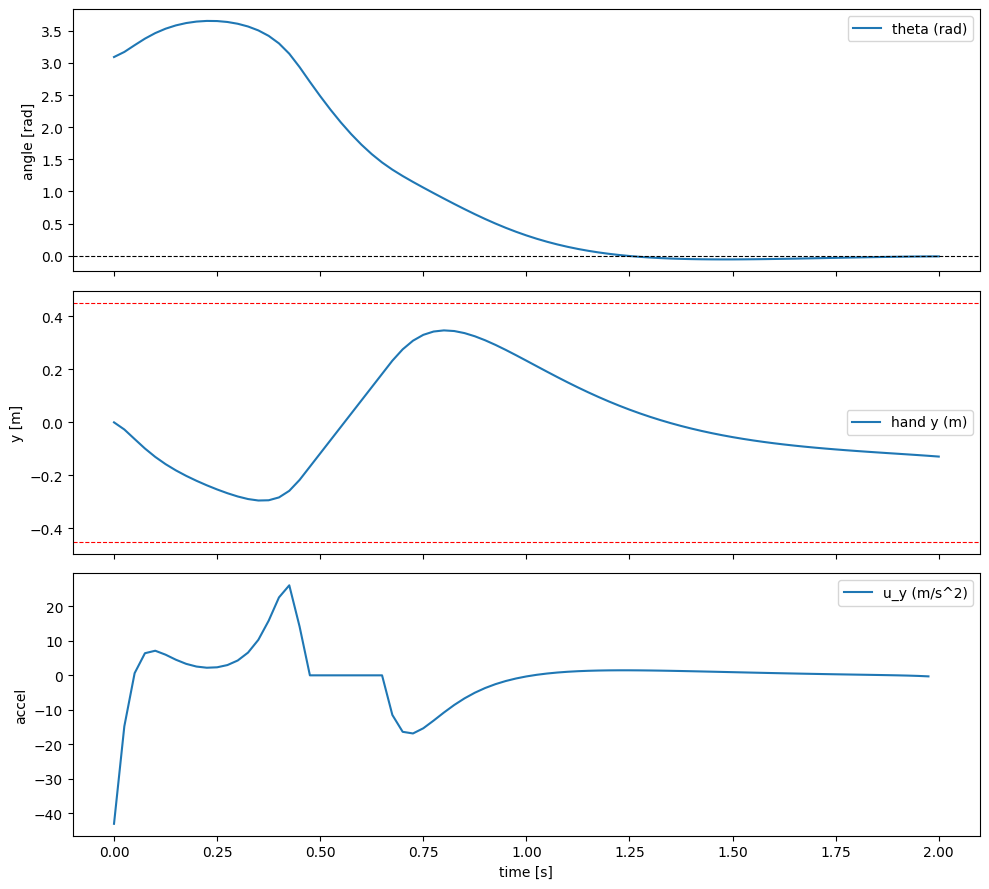

In [27]:
def plot_plan(plan):
    t = np.arange(len(plan['theta'])) * plan['step_dt']
    fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
    axs[0].plot(t, plan['theta'], label='theta (rad)')
    axs[0].axhline(0, color='k', linestyle='--', linewidth=0.8)
    axs[0].set_ylabel('angle [rad]')
    axs[0].legend()
    axs[1].plot(t, plan['y'], label='hand y (m)')
    axs[1].axhline(Y_MAX, color='r', linestyle='--', linewidth=0.8)
    axs[1].axhline(-Y_MAX, color='r', linestyle='--', linewidth=0.8)
    axs[1].set_ylabel('y [m]')
    axs[1].legend()
    axs[2].plot(t[:-1], plan['u'], label='u_y (m/s^2)')
    axs[2].set_ylabel('accel')
    axs[2].set_xlabel('time [s]')
    axs[2].legend()
    fig.tight_layout()
    return fig, axs

plot_plan(plan)


argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
t	des_theta	act_theta	u	des_y	act_y	des_y_dot	act_y_dot	y_target
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash

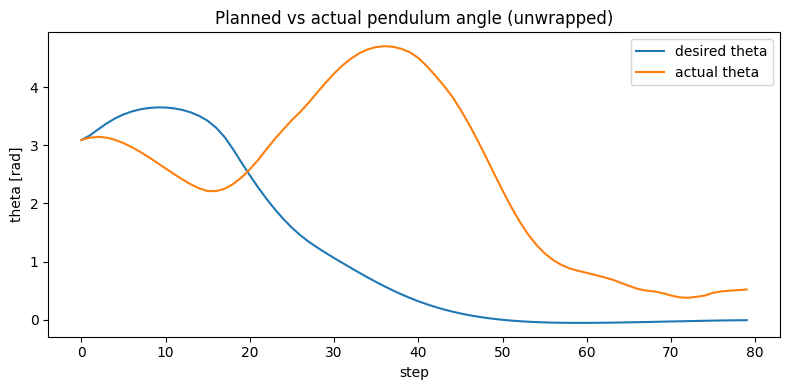

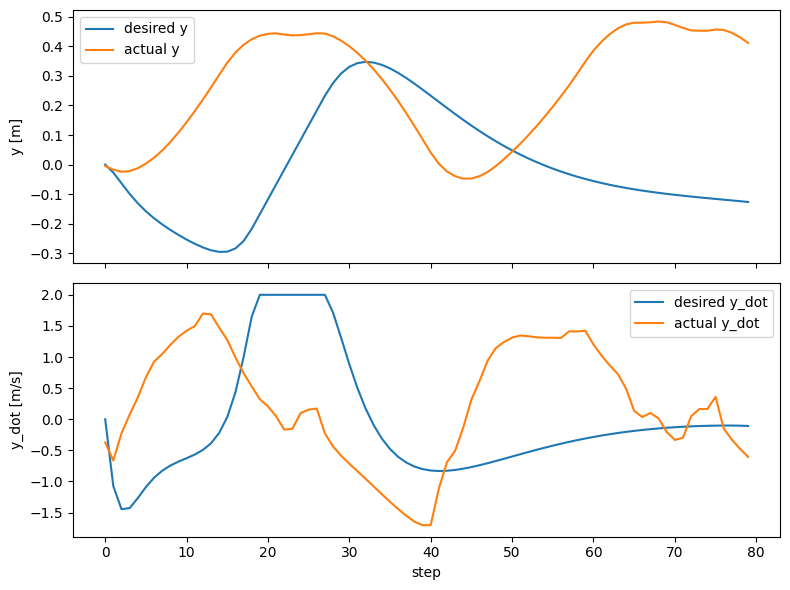

In [28]:
def rollout_plan_in_env(env, plan, gui=False):
    actions = []
    rewards = []
    desired_thetas = []
    actual_thetas = []
    desired_y = []
    actual_y = []
    desired_y_dot = []
    actual_y_dot = []
    print('t	des_theta	act_theta	u	des_y	act_y	des_y_dot	act_y_dot	y_target')
    for k, u in enumerate(plan['u']):
        target = np.clip(u / (abs(u) + 1e-8), -1.0, 1.0)
        action = np.array([[target]], dtype=np.float32)
        obs, reward, terminated, _, info = env.step(action)
        des_theta = plan['theta'][min(k, len(plan['theta']) - 1)]
        des_y_val = plan['y'][min(k, len(plan['y']) - 1)]
        des_y_dot_val = plan['y_dot'][min(k, len(plan['y_dot']) - 1)]
        act_theta = obs[0]
        act_y = obs[9]
        act_y_dot = obs[12]
        y_target = env.current_y_target if hasattr(env, 'current_y_target') else np.nan
        print(f"{k:03d}	{des_theta:+.3f}	{act_theta:+.3f}	{u:+.3f}	{des_y_val:+.3f}	{act_y:+.3f}	{des_y_dot_val:+.3f}	{act_y_dot:+.3f}	{y_target:+.3f}")
        actions.append(action)
        rewards.append(reward)
        desired_thetas.append(des_theta)
        actual_thetas.append(act_theta)
        desired_y.append(des_y_val)
        actual_y.append(act_y)
        desired_y_dot.append(des_y_dot_val)
        actual_y_dot.append(act_y_dot)
        if terminated:
            break
    des_t = np.array(desired_thetas)
    act_t = np.array(actual_thetas)
    des_unwrap = np.unwrap(des_t)
    act_unwrap = np.unwrap(act_t)
    offset = des_unwrap[0] - act_unwrap[0]
    act_unwrap += offset
    return (
        np.array(actions),
        np.array(rewards),
        des_unwrap,
        act_unwrap,
        np.array(desired_y),
        np.array(actual_y),
        np.array(desired_y_dot),
        np.array(actual_y_dot),
    )

# Example (runs headless)
env = Task7PendulumEnv(gui=True, should_balance=False, sim_substeps=SIM_SUBSTEPS, continuous_actions=True)
_, out = env.reset()
rollout_actions, rollout_rewards, des_t, act_t, des_y, act_y, des_y_dot, act_y_dot = rollout_plan_in_env(env, plan, gui=True)
env.close()
print('Rollout length:', len(rollout_actions))

# Plot desired vs actual theta (unwrapped)
plt.figure(figsize=(8, 4))
plt.plot(des_t, label='desired theta')
plt.plot(act_t, label='actual theta')
plt.xlabel('step')
plt.ylabel('theta [rad]')
plt.legend()
plt.title('Planned vs actual pendulum angle (unwrapped)')
plt.tight_layout()
plt.show()

# Plot desired vs actual y and y_dot
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(des_y, label='desired y')
axs[0].plot(act_y, label='actual y')
axs[0].set_ylabel('y [m]')
axs[0].legend()
axs[1].plot(des_y_dot, label='desired y_dot')
axs[1].plot(act_y_dot, label='actual y_dot')
axs[1].set_ylabel('y_dot [m/s]')
axs[1].set_xlabel('step')
axs[1].legend()
fig.tight_layout()
plt.show()


In [23]:
from datetime import datetime

def record_plan_rollout(plan, filename_prefix="task9_plan_rollout", gui=False):
    env = Task7PendulumEnv(gui=gui, should_balance=False, sim_substeps=SIM_SUBSTEPS, continuous_actions=True)
    env.set_initial_pendulum_angle(0)
    env.reset()
    obs_log, act_log, rew_log = [], [], []
    for u in plan['u']:
        action = np.array([[np.clip(u / (abs(u) + 1e-8), -1.0, 1.0)]], dtype=np.float32)
        obs, r, term, trunc, info = env.step(action)
        obs_log.append(obs.copy())
        act_log.append(action.copy())
        rew_log.append(r)
        if term or trunc:
            break
    env.close()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    out_path = Path('data') / f"{filename_prefix}_{timestamp}.npz"
    np.savez(out_path, observations=np.asarray(obs_log, np.float32), actions=np.asarray(act_log, np.float32), rewards=np.asarray(rew_log, np.float32))
    print('Saved rollout to', out_path)
    return out_path

def replay_rollout(file_path, gui=True):
    data = np.load(file_path)
    env = Task7PendulumEnv(gui=gui, should_balance=False, sim_substeps=SIM_SUBSTEPS, continuous_actions=True)
    env.set_initial_pendulum_angle(0)
    env.reset()
    for action in data['actions']:
        env.step(action)
    env.close()



In [24]:
def augment_obs_with_rollout(base_observations, rollout_file=None):
    """Load a saved rollout (npz) and return a list of sequences (base segments + rollout)."""
    data_dir = Path('data')
    if rollout_file is None:
        candidates = sorted(data_dir.glob('task9_plan_rollout_*.npz'))
        if not candidates:
            raise FileNotFoundError('No rollout files found in data/')
        rollout_file = candidates[-1]
    rollout_file = Path(rollout_file)
    roll = np.load(rollout_file)
    roll_obs = np.asarray(roll['observations'], dtype=np.float64)
    print('Loaded rollout', rollout_file, 'len=', len(roll_obs))
    sequences = []
    if isinstance(base_observations, (list, tuple)):
        for seq in base_observations:
            seq = np.asarray(seq, dtype=np.float64)
            if len(seq) > 0:
                sequences.append(seq)
    else:
        seq = np.asarray(base_observations, dtype=np.float64)
        if len(seq) > 0:
            sequences.append(seq)
    sequences.append(roll_obs)
    return sequences

# Example workflow:
# out_file = record_plan_rollout(plan, gui=False)
# sequences = augment_obs_with_rollout(observations, rollout_file=out_file)
# alpha1, alpha2, rmse = estimate_pendulum_params(sequences)
# print(alpha1, alpha2, rmse)


In [25]:
out_file = record_plan_rollout(plan, gui=False, filename_prefix="test_task9_plan_rollout")
aug_observations = augment_obs_with_rollout(aug_observations, rollout_file=out_file)
alpha1, alpha2, rmse = estimate_pendulum_params(aug_observations)
print(alpha1, alpha2, rmse)

argv[0]=--minLoggingLevel=3
Saved rollout to data/test_task9_plan_rollout_20251217_183148.npz
Loaded rollout data/test_task9_plan_rollout_20251217_183148.npz len= 80
4.028063079264155e-05 0.7133784498048998 0.37925642264865156


In [31]:
def rollout_recording_data_with_capture(record_data, gui=True, realtime=True, start_step=0, max_steps=None):
    actions = record_data['actions']
    obs = record_data['observations']
    total = len(actions)
    if total == 0:
        raise ValueError('Recording has no actions')
    if start_step < 0 or start_step >= total:
        raise ValueError(f'start_step {start_step} outside [0, {total})')
    end = total if max_steps is None else min(total, start_step + int(max_steps))
    start_idx = min(start_step, len(obs) - 1)
    initial_axis_angle = float(obs[start_idx][0]) + np.pi
    env_view = make_task8_env(gui=gui, initial_angle=initial_axis_angle)()
    env_view.reset()
    print("end",end)
    try:
        for step in range(start_step, end):
            obs_idx = min(step, len(obs) - 1)
            record_obs = obs[obs_idx]
            action = int(actions[step])
            pend_angle = float(record_obs[0])
            y_pos = float(record_obs[9])
            print(f'Step {step:04d} | action={action} pend={pend_angle:+.3f} y={y_pos:+.3f}')
            if step in [0,40,53,60,75,85]:
                env_view.capture_snapshot(file_path="videos/demo/snapshot_"+str(step)+".png")
            env_view.step(action)
            if gui and realtime:
                time.sleep(env_view.dt)
    finally:
        env_view.close()


In [ ]:
def rollout_plan_in_env(env, plan, gui=False):
    actions = []
    rewards = []
    desired_thetas = []
    actual_thetas = []
    desired_y = []
    actual_y = []
    desired_y_dot = []
    actual_y_dot = []
    print('t	des_theta	act_theta	u	des_y	act_y	des_y_dot	act_y_dot	y_target')
    for k, u in enumerate(plan['u']):
        target = np.clip(u / (abs(u) + 1e-8), -1.0, 1.0)
        action = np.array([[target]], dtype=np.float32)
        obs, reward, terminated, _, info = env.step(action)
        des_theta = plan['theta'][min(k, len(plan['theta']) - 1)]
        des_y_val = plan['y'][min(k, len(plan['y']) - 1)]
        des_y_dot_val = plan['y_dot'][min(k, len(plan['y_dot']) - 1)]
        act_theta = obs[0]
        act_y = obs[9]
        act_y_dot = obs[12]
        y_target = env.current_y_target if hasattr(env, 'current_y_target') else np.nan
        actions.append(action)
        rewards.append(reward)
        desired_thetas.append(des_theta)
        actual_thetas.append(act_theta)
        desired_y.append(des_y_val)
        actual_y.append(act_y)
        desired_y_dot.append(des_y_dot_val)
        actual_y_dot.append(act_y_dot)
        if terminated:
            break
    des_t = np.array(desired_thetas)
    act_t = np.array(actual_thetas)
    des_unwrap = np.unwrap(des_t)
    act_unwrap = np.unwrap(act_t)
    offset = des_unwrap[0] - act_unwrap[0]
    act_unwrap += offset
    return (
        np.array(actions),
        np.array(rewards),
        des_unwrap,
        act_unwrap,
        np.array(desired_y),
        np.array(actual_y),
        np.array(desired_y_dot),
        np.array(actual_y_dot),
    )

# Example (runs headless)
env = Task7PendulumEnv(gui=True, should_balance=False, sim_substeps=SIM_SUBSTEPS, continuous_actions=True)
_, out = env.reset()
rollout_actions, rollout_rewards, des_t, act_t, des_y, act_y, des_y_dot, act_y_dot = rollout_plan_in_env(env, plan, gui=True)
env.close()



argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun

In [29]:

# Closed-loop replanning (MPC-style) for the 4D Atkeson-style model.
# Planner state: [theta, theta_dot, y, y_dot]

EE_Y_IDX = globals().get('EE_Y_IDX', 9)
EE_YD_IDX = globals().get('EE_YD_IDX', 12)


def _obs_to_state4(obs):
    obs = np.asarray(obs, dtype=float)
    return np.array([obs[0], obs[1], obs[EE_Y_IDX], obs[EE_YD_IDX]], dtype=float)


def _plan_to_guess_4d(plan):
    X_guess = np.vstack(
        [
            np.asarray(plan['theta'], dtype=float),
            np.asarray(plan['theta_dot'], dtype=float),
            np.asarray(plan['y'], dtype=float),
            np.asarray(plan['y_dot'], dtype=float),
        ]
    )
    U_guess = np.asarray(plan['u'], dtype=float).reshape(1, -1)
    return X_guess, U_guess


def _shift_and_fit_guess(X_guess, U_guess, shift_steps, horizon_steps, start_state):
    """Shift a previous solution by shift_steps and pad/truncate to new horizon."""
    shift_steps = int(max(0, shift_steps))
    horizon_steps = int(horizon_steps)
    X = np.asarray(X_guess, dtype=float)
    U = np.asarray(U_guess, dtype=float)

    if X.shape[1] <= shift_steps:
        X = np.repeat(X[:, [-1]], repeats=(horizon_steps + 1), axis=1)
    else:
        X = X[:, shift_steps:]
    if U.shape[1] <= shift_steps:
        U = np.zeros((1, horizon_steps), dtype=float)
    else:
        U = U[:, shift_steps:]

    if X.shape[1] < horizon_steps + 1:
        X = np.hstack([X, np.repeat(X[:, [-1]], repeats=(horizon_steps + 1 - X.shape[1]), axis=1)])
    else:
        X = X[:, : horizon_steps + 1]

    if U.shape[1] < horizon_steps:
        U = np.hstack([U, np.repeat(U[:, [-1]], repeats=(horizon_steps - U.shape[1]), axis=1)])
    else:
        U = U[:, :horizon_steps]

    X[:, 0] = np.asarray(start_state, dtype=float)
    return X, U


def closed_loop_replanning(
    alpha1,
    alpha2,
    total_steps=80,
    horizon_steps=80,
    replan_every=5,
    gui=True,
):
    """Closed-loop replanning using the previous solution as a warm-start.

    Every `replan_every` steps, re-solve and warm-start with the last plan shifted by the
    number of executed steps.
    """
    env = Task7PendulumEnv(
        gui=gui,
        should_balance=False,
        sim_substeps=SIM_SUBSTEPS,
        continuous_actions=True,
    )
    obs, _ = env.reset()

    plan = None
    last_replan_step = 0

    log = {
        'theta': [],
        'theta_dot': [],
        'y': [],
        'y_dot': [],
        'u_cmd': [],
        'replan_steps': [],
    }

    for t in range(int(total_steps)):
        if t % int(replan_every) == 0:
            start_state = _obs_to_state4(obs)
            remaining = int(total_steps) - t
            horizon_now = min(int(horizon_steps), remaining)

            initial_guess = None
            if plan is not None:
                shift = t - last_replan_step
                X_prev, U_prev = _plan_to_guess_4d(plan)
                X_guess, U_guess = _shift_and_fit_guess(
                    X_prev, U_prev, shift_steps=shift, horizon_steps=horizon_now, start_state=start_state
                )
                initial_guess = (X_guess, U_guess)

            plan = plan_swing_up(
                alpha1,
                alpha2,
                horizon_steps=horizon_now,
                y_limit=0.6,
                y_vel_limit=2.0,
                start_state=start_state,
                weights={
                    'theta': 5.0,
                    'theta_dot': 0.5,
                    'y': 1.5 * 3,
                    'y_dot': 0.9,
                    'u': 0.0135,
                    'terminal_theta': 30.0,
                    'terminal_theta_dot': 4.0,
                },
                initial_guess=initial_guess,
            )

            last_replan_step = t
            log['replan_steps'].append(t)

        u_y = float(plan['u'][t - last_replan_step])
        # Map planner's acceleration-like signal to env's normalized action.
        u_cmd = float(np.clip(u_y / (abs(u_y) + 1e-8), -1.0, 1.0))
        obs, reward, terminated, truncated, info = env.step([[u_cmd]])

        log['theta'].append(float(obs[0]))
        log['theta_dot'].append(float(obs[1]))
        log['y'].append(float(obs[EE_Y_IDX]))
        log['y_dot'].append(float(obs[EE_YD_IDX]))
        log['u_cmd'].append(u_cmd)

        if terminated or truncated:
            break

    env.close()
    return log


# Example:
# log = closed_loop_replanning(alpha1, alpha2, total_steps=80, horizon_steps=80, replan_every=5, gui=True)



In [32]:
log = closed_loop_replanning(alpha1, alpha2, total_steps=80, horizon_steps=80, replan_every=15, gui=True)

argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun